# Handle missing values in Categorical Features

We will be use the xxxcars dataset to predict the price of the ADs. This dataset is full of missing values, categorical and not.

* **Replace** missing values with the *most frequent values*. It could lead to an unbalanced dataset.
* **Delete** rows with null values. It could lead to a loss of too many useful informations.
* **Predict** values using a Classifier Algorithm (supervised or unsupervised)


## Steps
* **Visualize Raw Data** descr.
* **Some Feature Engineering** descr.
* **1st Prediction** descr.
* **Deal with Categorical Data** descr.
* **Final Prediction** descr.

In [455]:
# Importing Libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

## Show Raw Data

In [456]:
# How raw data looks like
filename = "cars.csv"

dtypes = {
    "maker": str,
    "model": str,
    "mileage": float,
    "manufacture_year": float,
    "engine_displacement": float,
    "engine_power": float,
    "body_type": str,
    "color_slug": str,
    "stk_year": str,
    "transmission": str,
    "door_count": str,
    "seat_count": str,
    "fuel_type": str,
    "date_created": str,
    "date_last_seen": str,
    "price_eur": float}

df = pd.read_csv(filename, dtype=dtypes)
raw_shape = df.shape
print(f"Raw data has {raw_shape[0]} rows, and {raw_shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [457]:
# Missing values
print(df.isna().sum())

maker                   518915
model                  1133361
mileage                 362584
manufacture_year        370578
engine_displacement     743414
engine_power            554877
body_type              1122914
color_slug             3343411
stk_year               1708156
transmission            741630
door_count              614373
seat_count              749489
fuel_type              1847606
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


In [458]:
# Here we can see strage data, like the Min() of the features
df.describe()

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,3.190328e+06,3.182334e+06,2.809498e+06,2.998035e+06,3.552912e+06
mean,1.158140e+05,2.000871e+03,2.043958e+03,9.846796e+01,1.625812e+06
std,3.422508e+05,8.172588e+01,1.973958e+03,4.907309e+01,2.025622e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e-02
25%,1.880000e+04,2.004000e+03,1.400000e+03,6.800000e+01,1.295340e+03
50%,8.641500e+04,2.009000e+03,1.798000e+03,8.600000e+01,7.364910e+03
75%,1.580250e+05,2.013000e+03,1.997000e+03,1.100000e+02,1.628423e+04
max,9.999999e+06,2.017000e+03,3.276700e+04,2.237000e+03,2.706149e+12


## Some Feature Engineering

In [459]:
df = df[df["price_eur"] != 1295.34]
df = df[df["price_eur"] > 150.00]

# Manufacture Year
year_of_scepticism = 1970
average_years = df.loc[df["manufacture_year"] >= year_of_scepticism].\
groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()

df = df.merge(average_years, how="left", on=["maker", "model"])
df.loc[df["manufacture_year"] < year_of_scepticism, "manufacture_year"] = np.nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"])
df = df[df['manufacture_year'].notna()]

# Engine Power
min_engine_power = 50
average = df.loc[df["engine_power"] >= min_engine_power].\
groupby(["maker", "model"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_power"] < min_engine_power, "engine_power"] = np.nan
df["engine_power"] = df["engine_power"].fillna(df["avg_engine_power"])
df = df[df['engine_power'].notna()]

# Engine Displacement
min_engine_displacement = 600
average = df.loc[df["engine_displacement"] >= min_engine_displacement].\
groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_displacement"] < min_engine_displacement, "engine_displacement"] = np.nan
df["engine_displacement"] = df["engine_displacement"].fillna(df["engine_displacement"])
df = df[df['engine_displacement'].notna()]

# Mileage
features_to_fillna = ["mileage"]
for feature in features_to_fillna:
    replace_with = df[feature].mean() # deduce the mean
    df[feature].fillna(replace_with,inplace=True)


In [460]:
# let's transform str dates in datetimes and creare a new feature with the duration of ADs
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

**Replace** missing values with the *most frequent values*

In [461]:
# 
features_to_fillna = ["door_count", "seat_count"]
for feature in features_to_fillna:
    df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
    replace_with = df[feature].median()                       # deduce the median
    df[feature].fillna(replace_with,inplace=True)             # replace null
    
df["seat_str"] = np.select(
    condlist=[
        (df["seat_count"] >= 0) & (df["seat_count"] < 4),
        (df["seat_count"] >= 4) & (df["seat_count"] < 6),
        (df["seat_count"] >= 6)],
    choicelist=[
        "small",
        "medium",
        "large",
        ],
    default="unknown")
df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)
df = df.drop(["door_count"], axis=1)

**Delete** rows with null values.

In [462]:
#
df = df[df['fuel_type'].notna()]
df = pd.get_dummies(df,columns=["fuel_type"])

df = df[df['transmission'].notna()]
df = pd.get_dummies(df,columns=["transmission"])

In [463]:
# drop features
features_to_drop = ["model", "body_type", "color_slug", "stk_year", "avg_manufacture_year", "date_created", "date_last_seen", "avg_engine_power", "avg_engine_displacement"]
df = df.drop(features_to_drop, axis="columns")
df.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,74,1,0,0,1,0,0,1
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,74,0,1,0,1,0,0,1
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,74,0,1,0,1,0,0,1
3,skoda,111970.0,2004.0,1200.0,64.0,2960.77,74,0,1,0,0,1,0,1
4,skoda,128886.0,2004.0,1200.0,64.0,2738.71,74,0,1,0,0,1,0,1


In [464]:
# Missing values
print(df.isna().sum())

maker                  212897
mileage                     0
manufacture_year            0
engine_displacement         0
engine_power                0
price_eur                   0
ad_duration                 0
seat_str_large              0
seat_str_medium             0
seat_str_small              0
fuel_type_diesel            0
fuel_type_gasoline          0
transmission_auto           0
transmission_man            0
dtype: int64


Now we have to handle the **maker** feature. Let's see the difference between:
* **Delete** the entire column *Maker*.
* **Replace** values with the mode.
* **Delete** rows with null values.
* **Predict** the missing values.

In [465]:
mse_list = []
r2_score_list = []

def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

### Delete the entire column *Maker*.

In [466]:
df_no_maker = df.copy()
df_no_maker = df_no_maker.drop("maker", axis="columns")

df_no_maker = remove_outliers(df_no_maker)

X = df_no_maker.drop("price_eur", axis=1).values
Y = np.log1p(df_no_maker["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
df_no_maker.shape[0]

MSE: 0.1277556598232757
R2 score: 0.8588089375401112


766470

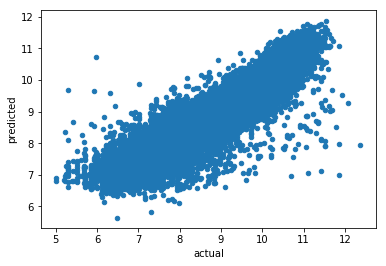

In [467]:
actual_predicted = pd.DataFrame({"predicted": Y_pred, 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")

## Replace values with the mode.

In [468]:
df_replace_mode = df.copy()

features_to_fillna = ["maker"]
for feature in features_to_fillna:
    replace_with = df_replace_mode[feature].mode()                       # deduce the median
    df_replace_mode[feature].fillna(replace_with,inplace=True)             # replace null

df_replace_mode = pd.get_dummies(df_replace_mode,columns=["maker"])

df_replace_mode = remove_outliers(df_replace_mode)

X = df_replace_mode.drop("price_eur", axis=1).values
Y = np.log1p(df_replace_mode["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
df_no_maker.shape[0]

MSE: 0.10692809518243727
R2 score: 0.8656743998324347


766470

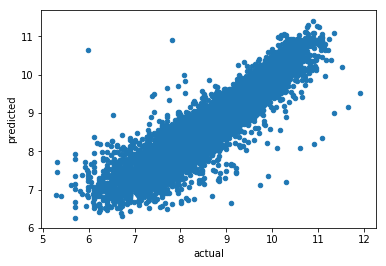

In [469]:
actual_predicted = pd.DataFrame({"predicted": Y_pred, 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")

## **Delete** rows with null values.

In [470]:
df_del_rows = df.copy()

df_del_rows = df_del_rows[df_del_rows['maker'].notna()]
df_del_rows = pd.get_dummies(df_del_rows,columns=["maker"])

df_del_rows = remove_outliers(df_del_rows)

X = df_del_rows.drop("price_eur", axis=1).values
Y = np.log1p(df_del_rows["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
df_del_rows.shape[0]

MSE: 0.09250613613991847
R2 score: 0.9036490623357628


274200

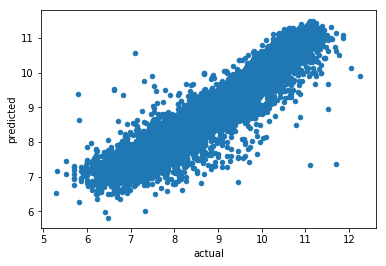

In [471]:
actual_predicted = pd.DataFrame({"predicted": Y_pred, 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")

## **Predict** the missing values.

In [472]:
df_with_maker = df[df['maker'].notna()]
# df_with_maker.info(null_counts=True)

df_no_maker = df[df['maker'].isna()]
df_no_maker.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212897 entries, 9 to 1153195
Data columns (total 14 columns):
maker                  0 non-null object
mileage                212897 non-null float64
manufacture_year       212897 non-null float64
engine_displacement    212897 non-null float64
engine_power           212897 non-null float64
price_eur              212897 non-null float64
ad_duration            212897 non-null int64
seat_str_large         212897 non-null uint8
seat_str_medium        212897 non-null uint8
seat_str_small         212897 non-null uint8
fuel_type_diesel       212897 non-null uint8
fuel_type_gasoline     212897 non-null uint8
transmission_auto      212897 non-null uint8
transmission_man       212897 non-null uint8
dtypes: float64(5), int64(1), object(1), uint8(7)
memory usage: 14.4+ MB


ACCURACY: TRAIN=0.9587 TEST=0.9156
LOG LOSS: 0.28757176873890095


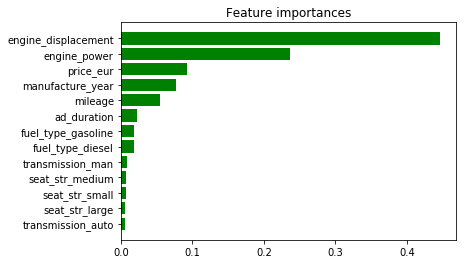

In [473]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]
# print(indices)

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_with_maker.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

#ACCURACY: TRAIN=0.9587 TEST=0.9156
#LOG LOSS: 0.28757176873890095

In [474]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = forest.predict(df_no_maker)

df_no_maker.insert(0, 'maker', prediction)

frames = [df_with_maker, df_no_maker]
df_final = pd.concat(frames)
print(len(df_final.index))
df_final.head()

867980


,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,fuel_type_diesel,fuel_type_gasoline,transmission_auto,transmission_man
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,74,1,0,0,1,0,0,1
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,74,0,1,0,1,0,0,1
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,74,0,1,0,1,0,0,1
3,skoda,111970.0,2004.0,1200.0,64.0,2960.77,74,0,1,0,0,1,0,1
4,skoda,128886.0,2004.0,1200.0,64.0,2738.71,74,0,1,0,0,1,0,1


In [475]:
df_final = pd.get_dummies(df_final,columns=["maker"])

df_final = remove_outliers(df_final)

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
#R2 score: 0.8904640737775003
df.shape[0]

MSE: 0.07756398386897533
R2 score: 0.8956970134024665


867980

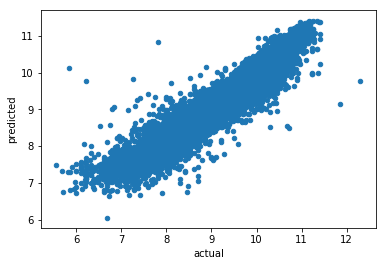

In [476]:
actual_predicted = pd.DataFrame({"predicted": ll.predict(X_test), 
                                  "actual": Y_test})

actual_predicted.plot.scatter(x="actual", y="predicted")

## Conclusions

In [481]:
options_list = [
    "Delete the entire column Maker", 
    "Replace values with the mode", 
    "Delete rows with null values", 
    "Predict the missing values"
]

df_metrics = pd.DataFrame({
    "": options_list,
    "MSE": mse_list,
    "R2_score": r2_score_list
})
df_metrics.head()

,,MSE,R2_score
0,Delete the entire column Maker,0.127756,0.858809
1,Replace values with the mode,0.106928,0.865674
2,Delete rows with null values,0.092506,0.903649
3,Predict the missing values,0.077564,0.895697
